In [ ]:

import os
import time
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import yfinance as yf
from fredapi import Fred

import lightning.pytorch as L
import torch
from torch import nn
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE
from torchmetrics.classification import Accuracy, BinaryF1Score, BinaryConfusionMatrix


In [ ]:

# Data download

def download_stock_data(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    data = yf.download(
        tickers=" ".join(tickers),
        start=start_date,
        end=end_date,
        group_by="ticker",
        auto_adjust=True,
        progress=False,
        threads=True,
    )
    return data


def download_macro_data(start_date: str, end_date: str, api_key: str) -> pd.DataFrame:
    indicators = {
        "UNRATE": "unemployment_rate",
        "CPIAUCSL": "cpi",
        "DFF": "fed_funds_rate",
        "DGS10": "treasury_10y",
    }
    if api_key:
        fred = Fred(api_key=api_key)
        df = pd.DataFrame()
        for code, name in indicators.items():
            try:
                series = fred.get_series(code, start=start_date, end=end_date)
                df[name] = series
            except Exception as e:
                print(f"Failed to download {code}: {e}")
        df = df.resample("D").ffill()
        return df
    else:
        return pd.DataFrame()


def flatten_stock_data(data: pd.DataFrame, tickers: List[str]) -> pd.DataFrame:
    flats = []
    for t in tickers:
        df = data[t].copy()
        df.columns = [f"{t}_{c.lower()}" for c in df.columns]
        flats.append(df)
    return pd.concat(flats, axis=1)


def filter_trading_days(data: pd.DataFrame) -> pd.DataFrame:
    try:
        import pandas_market_calendars as mcal
        nyse = mcal.get_calendar("NYSE")
        valid = nyse.valid_days(start_date=data.index.min(), end_date=data.index.max())
        return data[data.index.isin(valid.date)]
    except Exception:
        return data[data.index.dayofweek < 5]


def impute_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for col in df.columns:
        lower = col.lower()
        if df[col].isna().sum() == 0:
            continue
        if "volume" in lower:
            df[col].fillna(0, inplace=True)
        elif any(k in lower for k in ["close", "open", "high", "low"]):
            df[col].ffill(limit=2, inplace=True)
            df[col].interpolate(method="polynomial", order=2, limit=5, inplace=True)
        elif "return" in lower:
            df[col].fillna(0, inplace=True)
        else:
            missing_pct = df[col].isna().sum() / len(df)
            if missing_pct < 0.1:
                df[col].interpolate(method="linear", limit=5, inplace=True)
            else:
                df[col].ffill(inplace=True)
                df[col].bfill(inplace=True)
    thresh = int(len(df.columns) * 0.5)
    df = df.dropna(thresh=thresh)
    return df


def cap_outliers(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        if "volume" in col.lower():
            m = 4
        elif "return" in col.lower():
            m = 5
        else:
            m = 3
        lower = Q1 - m * IQR
        upper = Q3 + m * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df


def add_quality_score(data: pd.DataFrame) -> pd.DataFrame:
    score = 1 - data.isna().sum(axis=1) / len(data.columns)
    vol_cols = [c for c in data.columns if "volume" in c.lower()]
    if vol_cols:
        volume_quality = data[vol_cols].sum(axis=1) / (data[vol_cols].sum(axis=1).max() + 1e-10)
        score = 0.5 * score + 0.5 * volume_quality
    data["quality_score"] = score
    return data


def compute_technical_indicators(price_series: pd.Series) -> Dict[str, pd.Series]:
    delta = price_series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    period = 14
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    ema_short = price_series.ewm(span=12, adjust=False).mean()
    ema_long = price_series.ewm(span=26, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    window = 20
    sma = price_series.rolling(window).mean()
    std = price_series.rolling(window).std()
    upper_band = sma + 2 * std
    lower_band = sma - 2 * std
    return {
        "rsi": rsi,
        "macd_line": macd_line,
        "macd_signal": signal_line,
        "bb_upper": upper_band,
        "bb_lower": lower_band,
    }


def engineer_features(data: pd.DataFrame, tickers: List[str]) -> pd.DataFrame:
    features = []
    for ticker in tickers:
        cols = [c for c in data.columns if c.startswith(f"{ticker}_")]
        stock = data[cols].copy()
        stock.columns = [c.replace(f"{ticker}_", "") for c in stock.columns]
        for p in [1, 2, 3, 5, 10, 20, 60]:
            stock[f"return_{p}d"] = stock["close"].pct_change(p)
            stock[f"log_return_{p}d"] = np.log(stock["close"] / stock["close"].shift(p))
        stock["high_low_ratio"] = stock["high"] / stock["low"]
        stock["close_open_ratio"] = stock["close"] / stock["open"]
        stock["price_range"] = stock["high"] - stock["low"]
        stock["price_position"] = (stock["close"] - stock["low"]) / (stock["high"] - stock["low"] + 1e-10)
        for w in [5, 10, 20, 30, 50, 60, 200]:
            sma = stock["close"].rolling(w).mean()
            ema = stock["close"].ewm(span=w).mean()
            stock[f"sma_{w}"] = sma
            stock[f"ema_{w}"] = ema
            stock[f"close_to_sma_{w}"] = stock["close"] / (sma + 1e-10)
        for fast, slow in [(5, 20), (10, 30), (20, 60), (50, 200)]:
            stock[f"momentum_{fast}_{slow}"] = (stock[f"sma_{fast}"] + 1e-10) / (stock[f"sma_{slow}"] + 1e-10)
        for w in [5, 10, 20, 60]:
            stock[f"volatility_{w}d"] = stock["return_1d"].rolling(w).std()
        stock["dollar_volume"] = stock["close"] * stock["volume"]
        stock["amihud"] = stock["return_1d"].abs() / (stock["dollar_volume"] + 1e-10)
        stock["price_impact"] = stock["return_1d"].abs() / np.sqrt(stock["volume"] + 1e-10)
        tech = compute_technical_indicators(stock["close"])
        for name, series in tech.items():
            stock[name] = series
        stock["ticker"] = ticker
        features.append(stock)
    feats = pd.concat(features, axis=0)
    feats.sort_index(inplace=True)
    return feats


def add_portfolio_features(features: pd.DataFrame, tickers: List[str]) -> pd.DataFrame:
    returns = [features[features["ticker"] == t]["return_1d"] for t in tickers]
    portfolio_return = pd.concat(returns, axis=1).mean(axis=1)
    features["portfolio_return"] = portfolio_return.reindex(features.index)
    return features


def add_regime_and_temporal(features: pd.DataFrame, raw: pd.DataFrame) -> pd.DataFrame:
    idx = features.index
    features["day_of_week"] = idx.dayofweek
    features["week_sin"] = np.sin(2 * np.pi * idx.dayofyear / 7)
    features["week_cos"] = np.cos(2 * np.pi * idx.dayofyear / 7)
    features["month_sin"] = np.sin(2 * np.pi * idx.month / 12)
    features["month_cos"] = np.cos(2 * np.pi * idx.month / 12)
    return features


def create_targets(features: pd.DataFrame) -> pd.DataFrame:
    df = features.copy()
    df["future_return"] = df["portfolio_return"].shift(-1)
    df["target"] = (df["future_return"] > 0).astype(int)
    df["target_2d"] = (df["portfolio_return"].rolling(2).mean().shift(-1) > 0).astype(int)
    df["target_5d"] = (df["portfolio_return"].rolling(5).mean().shift(-1) > 0).astype(int)
    return df


def prepare_tft_datasets(df: pd.DataFrame) -> Tuple[TimeSeriesDataSet, TimeSeriesDataSet]:
    df = df.dropna(subset=["target"]).copy()
    df = df.reset_index().rename(columns={"Date": "date"})
    df["time_idx"] = df.groupby("ticker").cumcount()
    df["global_time_idx"] = (df["date"] - df["date"].min()).dt.days
    cutoff = df["global_time_idx"].max() - 365
    train = df[df["global_time_idx"] <= cutoff].copy()
    val = df[df["global_time_idx"] > cutoff].copy()
    train["ticker"] = train["ticker"].astype("category")
    val["ticker"] = val["ticker"].astype("category")
    cont_features = [
        c
        for c in df.columns
        if c not in ["target", "target_2d", "target_5d", "future_return", "global_time_idx", "date", "ticker"]
        and df[c].dtype.kind in "if"
    ]
    all_features = ["time_idx", "global_time_idx"] + cont_features
    train = train.dropna(subset=all_features)
    val = val.dropna(subset=all_features)
    train_ds = TimeSeriesDataSet(
        train,
        time_idx="time_idx",
        target="future_return",
        group_ids=["ticker"],
        max_encoder_length=60,
        max_prediction_length=1,
        static_categoricals=["ticker"],
        time_varying_known_reals=["time_idx", "global_time_idx"],
        time_varying_unknown_reals=cont_features,
    )
    val_ds = TimeSeriesDataSet.from_dataset(train_ds, val, stop_randomization=True)
    return train_ds, val_ds


In [ ]:

# Configuration
# Define your tickers and date range

TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]
START_DATE = "2019-01-01"
END_DATE = time.strftime("%Y-%m-%d")

# Set your FRED API key if available (otherwise macro data will be skipped)
os.environ["FRED_API_KEY"] = "77d281bb667042f8c178a5401b207628"
FRED_KEY = os.environ["FRED_API_KEY"]


In [ ]:

# Data ingestion
stock = download_stock_data(TICKERS, START_DATE, END_DATE)
macro = download_macro_data(START_DATE, END_DATE, FRED_KEY)
raw = flatten_stock_data(stock, TICKERS)
if not macro.empty:
    raw = raw.join(macro, how="left")

print(f"Raw data shape: {raw.shape}")


Raw data shape: (1727, 29)


In [ ]:

# Preprocessing
raw = filter_trading_days(raw)
raw = impute_missing_values(raw)
raw = cap_outliers(raw)
raw = add_quality_score(raw)
print("Preprocessed data shape:", raw.shape)
print(raw.head())


Preprocessed data shape: (1727, 30)
            AAPL_open  AAPL_high   AAPL_low  AAPL_close  AAPL_volume  \
Date                                                                   
2019-01-02  36.818564  37.759889  36.661676   37.538818  148158800.0   
2019-01-03  34.225167  34.638779  33.754506   33.799671  322700850.0   
2019-01-04  34.355912  35.311499  34.182386   35.242561  234428400.0   
2019-01-07  35.347156  35.378059  34.681573   35.164120  219111200.0   
2019-01-08  35.551584  36.088807  35.304370   35.834457  164101200.0   

            MSFT_open  MSFT_high   MSFT_low  MSFT_close  MSFT_volume  ...  \
Date                                                                  ...   
2019-01-02  93.317966  95.380239  92.746153   94.789680   35329300.0  ...   
2019-01-03  93.833546  93.917916  91.115090   91.302574   42579100.0  ...   
2019-01-04  93.477332  96.092673  92.736787   95.548981   44060600.0  ...   
2019-01-07  95.277132  96.805088  94.658453   95.670837   35656100.0  ... 

/tmp/ipykernel_40775/4193921816.py:52: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return data[data.index.isin(valid.date)]
/tmp/ipykernel_40775/4193921816.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].interpolate(method="linear", limit=5, inplace=True)
/tmp/ipykernel_40775/4193921816.py:75: FutureWarning:

In [ ]:

# Feature engineering
feats = engineer_features(raw, TICKERS)
feats = add_portfolio_features(feats, TICKERS)
feats = add_regime_and_temporal(feats, raw)
feats = feats.join(raw[["quality_score"]], how="left")
print("Features shape:", feats.shape)


Features shape: (8635, 68)


In [ ]:

# Create targets
feats = create_targets(feats)
feats = feats.dropna(subset=["future_return"])
print(feats[["portfolio_return", "future_return", "target"]].head())


            portfolio_return  future_return  target
Date                                               
2019-01-02               NaN       -0.04995       0
2019-01-03          -0.04995       -0.04995       0
2019-01-03          -0.04995       -0.04995       0
2019-01-03          -0.04995       -0.04995       0
2019-01-03          -0.04995       -0.04995       0


In [ ]:
def prepare_tft_datasets(df: pd.DataFrame) -> Tuple[TimeSeriesDataSet, TimeSeriesDataSet]:
    df = df.dropna(subset=["target"]).copy()
    df = df.reset_index().rename(columns={"Date": "date"})
    df["time_idx"] = df.groupby("ticker").cumcount()
    df["global_time_idx"] = (df["date"] - df["date"].min()).dt.days

    known_reals = [
        c
        for c in df.columns
        if c not in [
            "target", "target_2d", "target_5d", "future_return",
            "global_time_idx", "date", "ticker", "time_idx"
        ]
        and df[c].dtype.kind in "if"
    ]
    unknown_reals = ["future_return"]

    all_features = ["time_idx", "global_time_idx"] + known_reals + unknown_reals
    df = df.dropna(subset=all_features)

    cutoff = df["global_time_idx"].max() - 365
    train = df[df["global_time_idx"] <= cutoff].copy()
    val = df[df["global_time_idx"] > cutoff].copy()

    train["ticker"] = train["ticker"].astype("category")
    val["ticker"] = val["ticker"].astype("category")

    # Define the final datasets
    train_ds = TimeSeriesDataSet(
        train,
        time_idx="time_idx",
        target="target",
        group_ids=["ticker"],
        max_encoder_length=60,
        max_prediction_length=1,
        static_categoricals=["ticker"],
        time_varying_known_reals=["time_idx", "global_time_idx"] + known_reals,
        time_varying_unknown_reals=unknown_reals,
        target_normalizer=None,
    )
    val_ds = TimeSeriesDataSet.from_dataset(train_ds, val, stop_randomization=True)
    return train_ds, val_ds

In [ ]:

# Dataset preparation
train_ds, val_ds = prepare_tft_datasets(feats)
print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))

Training samples: 6090
Validation samples: 949


In [ ]:
import lightning.pytorch as L
from pytorch_forecasting.metrics import MAE

# 1. Define the Robust Classifier Class
class TFTClassifier(TemporalFusionTransformer):
    """
    A TemporalFusionTransformer wrapper designed for binary classification.
    Overrides internal methods to correctly handle nn.BCEWithLogitsLoss and
    disable unnecessary target scaling logic.
    """
    def __init__(self, **kwargs):
        desired_loss = kwargs.pop("loss")

        super().__init__(loss=MAE(), **kwargs)

        self.loss = desired_loss

    def transform_output(self, prediction: torch.Tensor, target_scale: torch.Tensor, loss=None) -> torch.Tensor:
        """Bypass all scaling and return raw prediction (logits)."""
        return prediction

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        y_hat = out["prediction"]

        loss = self.loss(y_hat.squeeze(-1), y[0].float())
        self.log_dict({"train_loss": loss}, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        y_hat = out["prediction"]

        loss = self.loss(y_hat.squeeze(-1), y[0].float())
        self.log_dict({"val_loss": loss}, on_epoch=True, on_step=False)
        return loss

train_loader = train_ds.to_dataloader(train=True, batch_size=64, num_workers=4)
val_loader = val_ds.to_dataloader(train=False, batch_size=64, num_workers=4)

# Use the custom classifier class
model = TFTClassifier.from_dataset(
    train_ds,
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=1,  # Single logit
    loss=nn.BCEWithLogitsLoss(), # Pass the actual loss here
)

# 3. Trainer Setup
trainer = L.Trainer(
    max_epochs=20,
    gradient_clip_val=0.1,
    log_every_n_steps=20,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=1,
)

trainer.fit(model, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | BCEWithLogitsLoss               | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 20     | train
3  | prescalers                         | ModuleDict                      | 2.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 384    | train
5  | encoder_variable_selecti

/mnt/sdd/clean_tft_project/tftenv/lib/python3.13/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 95/95 [00:38<00:00,  2.47it/s, v_num=17]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 95/95 [00:40<00:00,  2.33it/s, v_num=17]      

/mnt/sdd/clean_tft_project/tftenv/lib/python3.13/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 53. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1: 100%|██████████| 95/95 [00:38<00:00,  2.47it/s, v_num=17] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 95/95 [00:38<00:00,  2.49it/s, v_num=17]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 95/95 [00:38<00:00,  2.50it/s, v_num=17]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 95/95 [00:38<00:00,  2.49it/s, v_num=17]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 95/95 [00:38<00:00,  2.47it/s, v_num=17]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 95/95 [00:38<00:00,  2.48it/s, v_num=17]      
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|█

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 95/95 [00:40<00:00,  2.32it/s, v_num=17]


CLASSIFICATION MODEL EVALUATION (Validation Set)
Validation Accuracy: 0.8830 (Probability of correct direction)
Validation F1 Score: 0.8962 (Harmonic mean of Precision/Recall)
Baseline (Random Guess): 0.50

Confusion Matrix:
Actual (Rows) vs. Predicted (Columns)
[[TN (Correct 0), FP (Incorrect 1)]
 [FN (Incorrect 0), TP (Correct 1)]]
[[359  60]
 [ 51 479]]

FINANCIAL (P&L SIMULATION) METRICS (Long-Only Strategy)
This shows the P&L if we ONLY trade when the model predicts 'Up' (1).
  Annualized Return (%): 12719.49%
  Annualized Volatility (%): 793.69%
  Sharpe Ratio: 16.026
  Max Drawdown (%): -300.00%
                                                                   

/tmp/ipykernel_40775/3196710735.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts.index, y=pred_counts.values, palette=["#EF4444", "#10B981"])


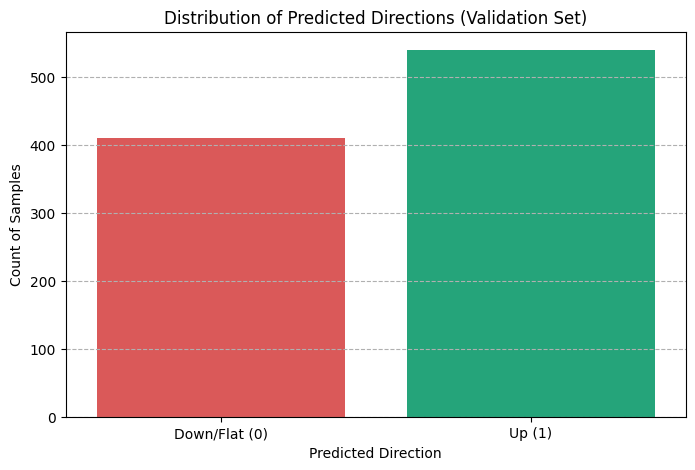

/tmp/ipykernel_40775/3196710735.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=true_counts.index, y=true_counts.values, palette=["#374151", "#9CA3AF"])


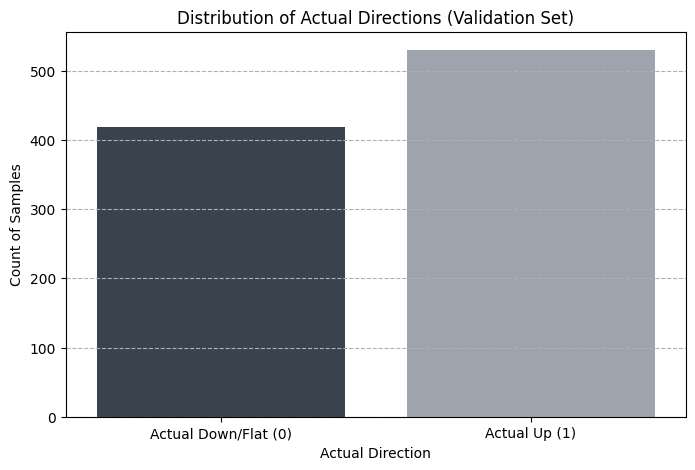

In [ ]:
import numpy as np
import pandas as pd
import torch
# Necessary classification metrics
from torchmetrics.classification import Accuracy, BinaryF1Score, BinaryConfusionMatrix

def calculate_financial_metrics(returns: np.ndarray, trading_days: int = 252):
    """
    Calculates Sharpe Ratio and Max Drawdown for the simulated strategy.

    DEBUG FIX: Ensures cumulative returns is converted to a Pandas Series
    to use the .expanding() method for Max Drawdown calculation.
    """
    cumulative_returns = pd.Series(1 + returns).cumprod()

    annualized_return = np.mean(returns) * trading_days
    volatility = returns.std() * np.sqrt(trading_days)

    sharpe = annualized_return / volatility if volatility != 0 else np.inf

    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns / peak) - 1.0
    mdd = drawdown.min()

    return {
        "Annualized Return (%)": annualized_return * 100,
        "Annualized Volatility (%)": volatility * 100,
        "Sharpe Ratio": sharpe,
        "Max Drawdown (%)": mdd * 100,
    }


# 1. Setup
# Ensure model is on the correct device if using GPU
device = next(model.parameters()).device
val_loader = val_ds.to_dataloader(train=False, batch_size=64, num_workers=4)

# Initialize Classification Metrics and move them to the device
accuracy = Accuracy(task="binary").to(device)
f1 = BinaryF1Score().to(device)
conf_matrix = BinaryConfusionMatrix().to(device)

model.eval()
all_predictions = []
all_true_classes = []
all_actual_returns = []

# 2. Prediction Loop
with torch.no_grad():
    for batch in val_loader:
        x, y = batch

        # Move batch inputs to device
        x = {key: val.to(device) if isinstance(val, torch.Tensor) else val for key, val in x.items()}

        # Get the single logit prediction
        logits = model(x)['prediction'].squeeze(-1)

        # Convert logits to classes (0 or 1)
        probabilities = torch.sigmoid(logits)
        pred_class = (probabilities > 0.5).long()


        true_values = y[0]
        true_class = true_values.long().to(device)

        # Collect results (on CPU)
        all_predictions.extend(pred_class.cpu().numpy())
        all_true_classes.extend(true_class.cpu().numpy())
        all_actual_returns.extend(true_values.cpu().numpy().flatten()) # Store continuous returns

        # Update classification metrics (on device)
        accuracy.update(pred_class, true_class)
        f1.update(pred_class, true_class)
        conf_matrix.update(pred_class, true_class)

# 3. Compute and Print Classification Metrics
print("="*50)
print("CLASSIFICATION MODEL EVALUATION (Validation Set)")
print("="*50)

acc = accuracy.compute().item()
f1_score = f1.compute().item()
cm = conf_matrix.compute().cpu().numpy()

print(f'Validation Accuracy: {acc:.4f} (Probability of correct direction)')
print(f'Validation F1 Score: {f1_score:.4f} (Harmonic mean of Precision/Recall)')
print(f'Baseline (Random Guess): 0.50')

print("\nConfusion Matrix:")
print("Actual (Rows) vs. Predicted (Columns)")
print(f"[[TN (Correct 0), FP (Incorrect 1)]\n [FN (Incorrect 0), TP (Correct 1)]]")
print(cm)

# 4. Financial (P&L Simulation) Metrics
# Convert prediction list back to a numpy array
predicted_direction = np.array(all_predictions)

# Simulate a simple long-only strategy:
# Buy (return = actual_return) if predicted_direction == 1 (Up), else Hold (return = 0).
actual_returns_array = np.array(all_actual_returns)

predicted_direction = predicted_direction.reshape(-1)
actual_returns_array = actual_returns_array.reshape(-1)

strategy_returns = actual_returns_array * predicted_direction

financial_results = calculate_financial_metrics(strategy_returns)

print("\n" + "="*50)
print("FINANCIAL (P&L SIMULATION) METRICS (Long-Only Strategy)")
print("This shows the P&L if we ONLY trade when the model predicts 'Up' (1).")
print("="*50)
for name, value in financial_results.items():
    if "%" in name:
        print(f"  {name}: {value:.2f}%")
    else:
        print(f"  {name}: {value:.3f}")
print("="*50)


# 5. Visualization (Prediction Distribution)
import matplotlib.pyplot as plt
import seaborn as sns

pred_counts = pd.Series(all_predictions).value_counts().sort_index()
pred_counts = pred_counts.reindex([0, 1], fill_value=0)
pred_counts.index = ["Down/Flat (0)", "Up (1)"]

plt.figure(figsize=(8, 5))
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette=["#EF4444", "#10B981"])
plt.title('Distribution of Predicted Directions (Validation Set)')
plt.xlabel('Predicted Direction')
plt.ylabel('Count of Samples')
plt.grid(axis='y', linestyle='--')
plt.show()

# 6. Visualization (Actual Class Balance)
true_counts = pd.Series(all_true_classes).value_counts().sort_index()
true_counts = true_counts.reindex([0, 1], fill_value=0)
true_counts.index = ["Actual Down/Flat (0)", "Actual Up (1)"]

plt.figure(figsize=(8, 5))
sns.barplot(x=true_counts.index, y=true_counts.values, palette=["#374151", "#9CA3AF"])
plt.title('Distribution of Actual Directions (Validation Set)')
plt.xlabel('Actual Direction')
plt.ylabel('Count of Samples')
plt.grid(axis='y', linestyle='--')
plt.show()